###### IMPORTING NECESSARY LIBRARIES

In [1]:
import pandas as pd
import re
import numpy as np
from text_unidecode import unidecode


import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,classification_report





# DATA

In [2]:
df_1 = pd.read_json('Sarcasm_Headlines_Dataset.json',lines = True)
df_2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines = True)

In [3]:
df_1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df_2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Since both the data sets look alike, we join them

In [5]:
df = pd.concat([df_1,df_2],axis = 0)

In [6]:
df.shape

(55328, 3)

In [7]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [9]:
df.isna().sum()


article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [10]:
df.drop('article_link',axis = 1,inplace = True)

In [11]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Preprocessing

## Data Cleaning

In [12]:
# Defining a regular expression pattern to match any character that is not a lowercase letter or white space 
regex = re.compile('[^a-z\s]')
# Converting the 'headline' column to lower case to ensure the uniformity
df['text'] = df['headline'].str.lower()
# Applying the regex substitution to remove all the charactors that are not lower cases and white spaces
df['text'] = df['text'].apply(lambda x: regex.sub('', x))
# Applying the unidecode function to remove accents from the text
df['text'] = df['text'].apply(lambda x: regex.sub('', unidecode(x)))
# Removing the substrings 'rt' and 'http' from the text using regular expression
df['text'] = df['text'].str.replace('rt|http', '', regex = True)
# Applying the lambda function to remove stop words with fewer than 3 
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

## Removing Stopwords

In [13]:
df['text'] = df['text'].apply(word_tokenize)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])
#Removing stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])


## Word Normalization

In [14]:
# word normalization
stemmer  = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x:[stemmer.stem(word) for word in x])

#Joining the words back into a single text
df['final_text'] = df['text'].apply(lambda x: ' '.join(x))


# VISUALIZATION

## Top 10 most used words

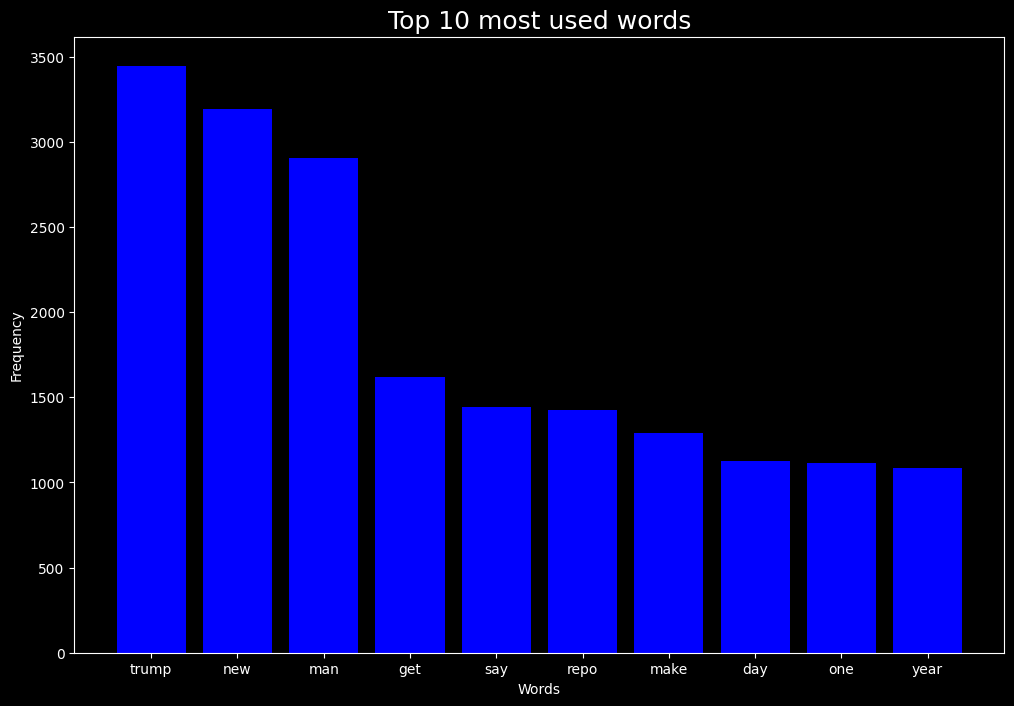

In [15]:
words = []
for text in df['final_text']:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

#Dark Background

plt.style.use('dark_background')
plt.figure(figsize = (12,8))

# Create the Barplot
plt.bar(range(len(top_words)),list(top_words.values()),align='center',color= 'blue')

plt.xticks(range(len(top_words)),list(top_words.keys()))
# Grid opacity
plt.grid(alpha=0)
#Title
plt.title('Top 10 most used words',fontsize=18)
#Labels
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

## Word Graph

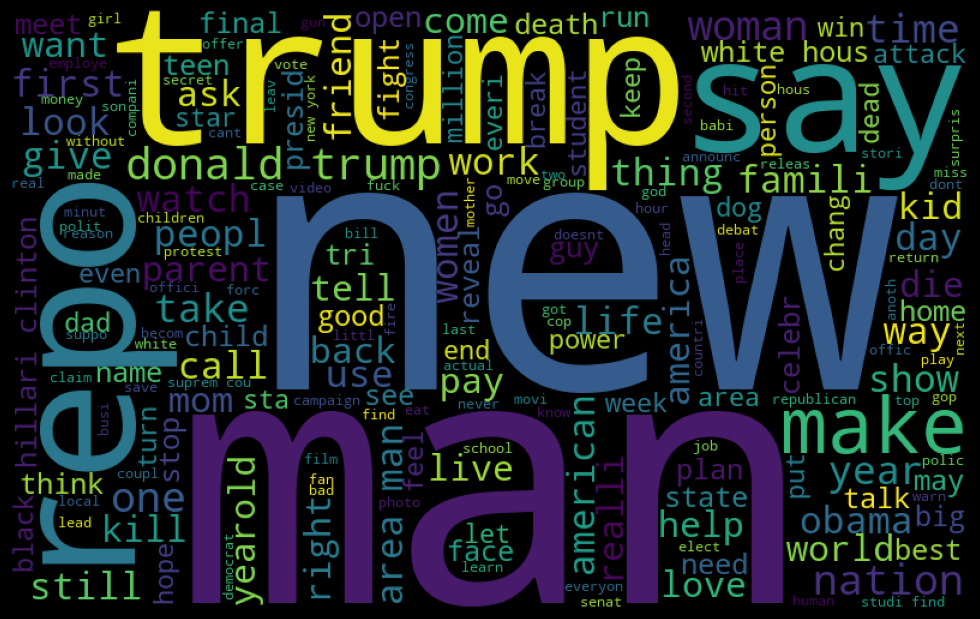

In [16]:
text = ' '.join(caption for caption in df['final_text'])

wordcloud = WordCloud(width = 800 , height =500, background_color='black',min_font_size=10).generate(text)

plt.figure(figsize =(10,6),facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# TRAINING

In [18]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

# Assuming you have already loaded your data into the 'df' DataFrame

# Extract features and labels
X = np.array(df['final_text'])
y = np.array(df['is_sarcastic'])

# Convert text to numerical using CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Sort the indices of X_train and X_test
X_train.sort_indices()
X_test.sort_indices()

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)



In [19]:
# Define a neural network model for binary classification
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(2, activation='softmax'))  # Two output neurons for two classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                1243776   
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1243906 (4.75 MB)
Trainable params: 1243906 (4.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
346/346 [==============================] - 5s 14ms/step - loss: 0.2460 - accuracy: 0.9030 - val_loss: 0.2910 - val_accuracy: 0.8821
Epoch 2/10
346/346 [==============================] - 5s 14ms/step - loss: 0.1653 - accuracy: 0.9411 - val_loss: 0.2551 - val_accuracy: 0.9072
Epoch 3/10
346/346 [==============================] - 5s 14ms/step - loss: 0.1172 - accuracy: 0.9621 - val_loss: 0.2380 - val_accuracy: 0.9195
Epoch 4/10
346/346 [==============================] - 5s 14ms/step - loss: 0.0829 - accuracy: 0.9760 - val_loss: 0.2295 - val_accuracy: 0.9284
Epoch 5/10
346/346 [==============================] - 5s 15ms/step - loss: 0.0571 - accuracy: 0.9855 - val_loss: 0.2268 - val_accuracy: 0.9376
Epoch 6/10
346/346 [==============================] - 5s 14ms/step - loss: 0.0390 - accuracy: 0.9910 - val_loss: 0.2290 - val_accuracy: 0.9426
Epoch 7/10
346/346 [==============================] - 5s 14ms/step - loss: 0.0260 - accuracy: 0.9952 - val_loss: 0.2408 - val_accuracy: 0.9434

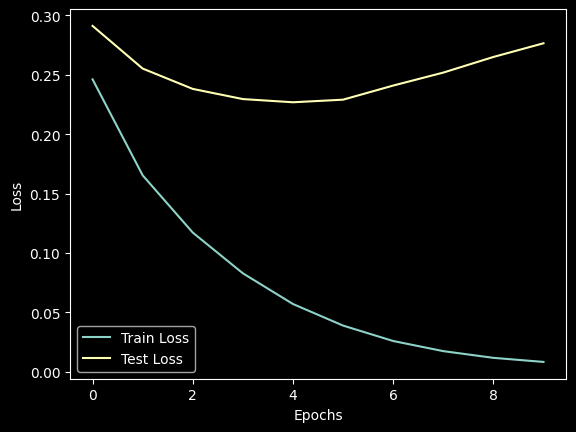

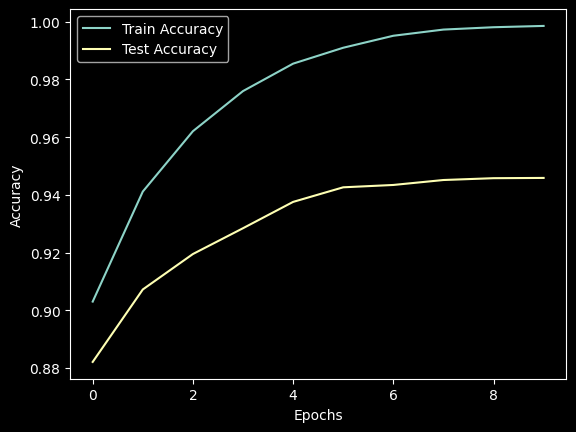

346/346 [==============================] - 0s 1ms/step
Test Set Accuracy: 94.58702331465751%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6032
           1       0.95      0.93      0.94      5034

    accuracy                           0.95     11066
   macro avg       0.95      0.94      0.95     11066
weighted avg       0.95      0.95      0.95     11066



In [21]:
# Lists to store training and testing history
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Plot training and testing loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)  # Convert probabilities to class labels

accuracy = accuracy_score(np.argmax(y_test, axis=1), test_pred)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_pred)

print(f"Test Set Accuracy: {accuracy * 100}%")
print(classification_rep)


Epoch 1/10
346/346 [==============================] - 42s 118ms/step - loss: 0.4033 - accuracy: 0.8103 - val_loss: 0.2587 - val_accuracy: 0.8978
Epoch 2/10
346/346 [==============================] - 40s 117ms/step - loss: 0.1129 - accuracy: 0.9617 - val_loss: 0.1707 - val_accuracy: 0.9402
Epoch 3/10
346/346 [==============================] - 40s 115ms/step - loss: 0.0182 - accuracy: 0.9952 - val_loss: 0.1823 - val_accuracy: 0.9534
Epoch 4/10
346/346 [==============================] - 40s 115ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.2227 - val_accuracy: 0.9544
Epoch 5/10
346/346 [==============================] - 40s 115ms/step - loss: 9.1228e-04 - accuracy: 0.9997 - val_loss: 0.2454 - val_accuracy: 0.9553
Epoch 6/10
346/346 [==============================] - 40s 116ms/step - loss: 3.1491e-04 - accuracy: 1.0000 - val_loss: 0.2604 - val_accuracy: 0.9554
Epoch 7/10
346/346 [==============================] - 40s 115ms/step - loss: 1.2044e-04 - accuracy: 1.0000 - val_loss: 0.2

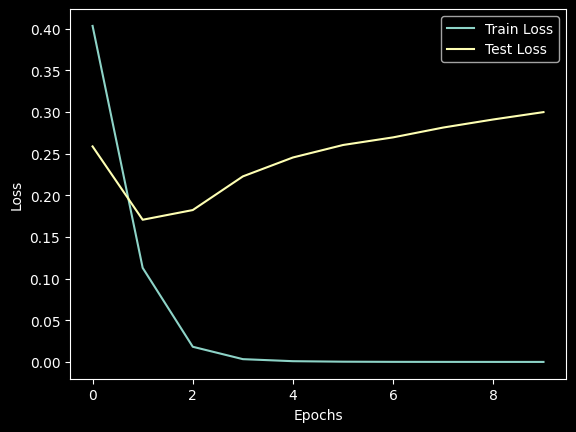

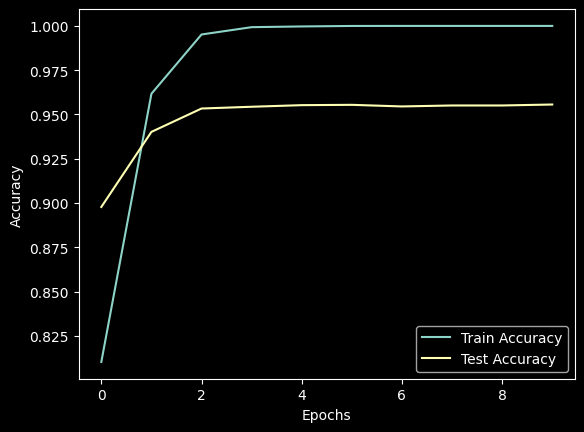

346/346 [==============================] - 4s 12ms/step
Test Set Accuracy: 95.56298572203144%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6032
           1       0.96      0.94      0.95      5034

    accuracy                           0.96     11066
   macro avg       0.96      0.95      0.96     11066
weighted avg       0.96      0.96      0.96     11066



In [36]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Assuming you have already loaded your data into the 'df' DataFrame

# Extract features and labels
X = np.array(df['final_text'])
y = np.array(df['is_sarcastic'])

# Tokenize and pad the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define a CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Two output neurons for two classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Lists to store training and testing history
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Plot training and testing loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)  # Convert probabilities to class labels

accuracy = accuracy_score(np.argmax(y_test, axis=1), test_pred)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_pred)

print(f"Test Set Accuracy: {accuracy * 100}%")
print(classification_rep)


In [28]:
# Define a CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Two output neurons for two classes
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 106, 100)          1943400   
                                                                 
 conv1d_2 (Conv1D)           (None, 102, 128)          64128     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2015914 (7.69 MB)
Trainable params: 2015914 (7.69 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 106, 100)          1943400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2069034 (7.89 MB)
Trainable params: 2069034 (7.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
346/346 [==============================] - 242s 688ms/step - loss: 0.4214 - accuracy: 0.7994 - val_loss: 0.3129 - val_accuracy: 0.8683
E

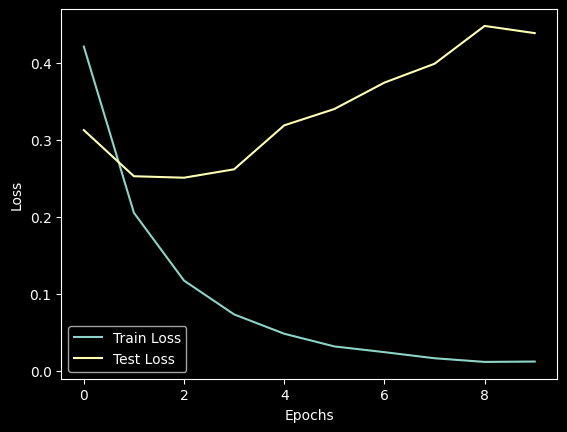

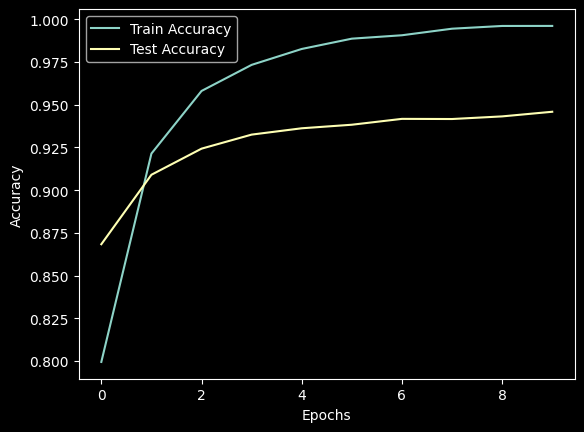

346/346 [==============================] - 20s 58ms/step
Test Set Accuracy: 94.58702331465751%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6032
           1       0.95      0.93      0.94      5034

    accuracy                           0.95     11066
   macro avg       0.95      0.94      0.95     11066
weighted avg       0.95      0.95      0.95     11066



In [41]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Assuming you have already loaded your data into the 'df' DataFrame

# Extract features and labels
X = np.array(df['final_text'])
y = np.array(df['is_sarcastic'])

# Tokenize and pad the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define an LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X_train.shape[1]))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Two output neurons for two classes

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Lists to store training and testing history
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Plot training and testing loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)  # Convert probabilities to class labels

accuracy = accuracy_score(np.argmax(y_test, axis=1), test_pred)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_pred)

print(f"Test Set Accuracy: {accuracy * 100}%")
print(classification_rep)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               13696     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 2)                 66        
                                                                 
Total params: 24098 (94.13 KB)
Trainable params: 24098 (94.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
346/346 [==============================] - 2s 4ms/step - loss: 20.8029 - accuracy: 0.5138 - val_loss: 6.6935 - val_accuracy: 0.5228
Epoch 

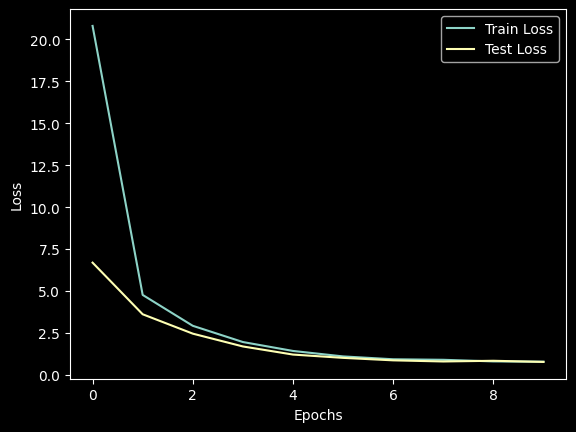

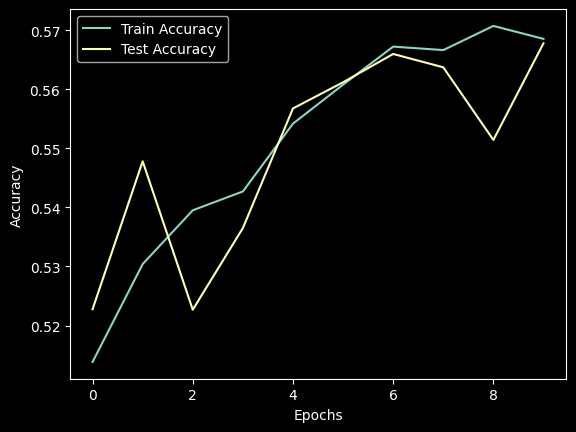

346/346 [==============================] - 1s 2ms/step
Test Set Accuracy: 56.77751671787456%
              precision    recall  f1-score   support

           0       0.57      0.89      0.69      6032
           1       0.58      0.18      0.28      5034

    accuracy                           0.57     11066
   macro avg       0.57      0.54      0.48     11066
weighted avg       0.57      0.57      0.50     11066



In [49]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Assuming you have already loaded your data into the 'df' DataFrame

# Extract features and labels
X = np.array(df['final_text'])
y = np.array(df['is_sarcastic'])

# Tokenize and pad the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Define an MLP model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Two output neurons for two classes

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Lists to store training and testing history
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

# Plot training and testing loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)  # Convert probabilities to class labels

accuracy = accuracy_score(np.argmax(y_test, axis=1), test_pred)
classification_rep = classification_report(np.argmax(y_test, axis=1), test_pred)

print(f"Test Set Accuracy: {accuracy * 100}%")
print(classification_rep)
